In [ ]:
thttps://upload.wikimedia.org/wikipedia/commons/2/2d/Toyota-Corolla-hatchback.jpg# If in Colab, this ensures a clean install
!pip -q install --upgrade ultralytics pillow opencv-python matplotlib

import torch, platform, sys
import ultralytics
print("Torch:", torch.__version__)
print("Ultralytics:", ultralytics.__version__)
print("Python:", sys.version)
print("Platform:", platform.platform())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 123.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Where to copy the trained weights on finish:
SAVE_TO = "/content/drive/MyDrive/kopiloto/carparts_best.pt"

Mounted at /content/drive


In [ ]:
import os, glob, shutil, zipfile

DATA_ZIP = "/content/carparts-seg.zip"
DATA_DIR = "/content/carparts-seg"

# Ensure target folder is clean
if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)
os.makedirs(DATA_DIR, exist_ok=True)

# Unzip into a temp folder
TEMP_DIR = "/content/_tmp_unzip"
if os.path.exists(TEMP_DIR):
    shutil.rmtree(TEMP_DIR)
os.makedirs(TEMP_DIR, exist_ok=True)

with zipfile.ZipFile(DATA_ZIP, 'r') as zf:
    zf.extractall(TEMP_DIR)

# Find if there's a wrapping folder
cands = [p for p in glob.glob(os.path.join(TEMP_DIR, "*")) if os.path.isdir(p)]
if len(cands) == 1 and not os.path.basename(cands[0]).startswith("images"):
    # There is a single wrapping folder → move its contents
    shutil.move(cands[0], DATA_DIR)
else:
    # No wrapping folder → move everything from temp into DATA_DIR
    for item in os.listdir(TEMP_DIR):
        shutil.move(os.path.join(TEMP_DIR, item), DATA_DIR)

shutil.rmtree(TEMP_DIR)
print("✅ Dataset ready at:", DATA_DIR)
!find {DATA_DIR} -maxdepth 2 -type d | sort

✅ Dataset ready at: /content/carparts-seg
/content/carparts-seg
/content/carparts-seg/images
/content/carparts-seg/images/test
/content/carparts-seg/images/train
/content/carparts-seg/images/val
/content/carparts-seg/labels
/content/carparts-seg/labels/test
/content/carparts-seg/labels/train
/content/carparts-seg/labels/val


In [ ]:
from pathlib import Path
import yaml

# Search for 'images' folder anywhere under /content
image_dirs = list(Path("/content").rglob("images"))
if not image_dirs:
    raise FileNotFoundError("No 'images' folder found inside dataset.")

# Take the parent folder of 'images' as dataset root
dataset_root = image_dirs[0].parent
print("✅ Found dataset root:", dataset_root)

# Write YAML pointing to correct path
yaml_data = {
    "path": str(dataset_root),
    "train": "images/train",
    "val": "images/val",
    "test": "images/test" if (dataset_root/"images/test").exists() else "images/val",
    "names": {
      0: "back_bumper",
      1: "back_door",
      2: "back_glass",
      3: "back_left_door",
      4: "back_left_light",
      5: "back_light",
      6: "back_right_door",
      7: "back_right_light",
      8: "front_bumper",
      9: "front_door",
      10: "front_glass",
      11: "front_left_door",
      12: "front_left_light",
      13: "front_light",
      14: "front_right_door",
      15: "front_right_light",
      16: "hood",
      17: "left_mirror",
      18: "object",
      19: "right_mirror",
      20: "tailgate",
      21: "trunk",
      22: "wheel"
    }
}

yaml_path = Path("/content/carparts-seg.yaml")
yaml.safe_dump(yaml_data, open(yaml_path, "w"), sort_keys=False)
print("✅ Wrote YAML:", yaml_path)

✅ Found dataset root: /content
✅ Wrote YAML: /content/carparts-seg.yaml


In [ ]:
!yolo task=segment mode=train \
    model=yolo11n-seg.pt \
    data=/content/carparts-seg.yaml \
    epochs=50 imgsz=640 batch=16

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/carparts-seg.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrain

In [ ]:
import torch, os
print("CUDA:", torch.cuda.is_available())

# Entrenamiento rápido: 10 epochs para validar pipeline
!yolo task=segment mode=train \
    model=yolo11n-seg.pt \
    data=/content/carparts-seg.yaml \
    epochs=10 imgsz=512 batch=16 amp=True cos_lr=True \
    project="runs_carparts_seg" name="train_y11n_seg_fast"

CUDA: True
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/carparts-seg.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_y11n_seg_fast, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=T

In [ ]:
!yolo task=segment mode=val \
    model=runs_carparts_seg/train_y11n_seg_fast/weights/best.pt \
    data=/content/carparts-seg.yaml

# Predicción rápida en una imagen demo
import urllib.request, os
os.makedirs("samples", exist_ok=True)
urllib.request.urlretrieve(
    "https://upload.wikimedia.org/wikipedia/commons/2/2d/Toyota-Corolla-hatchback.jpg",
    "samples/car.jpg"
)
!yolo task=segment mode=predict \
    model=runs_carparts_seg/train_y11n_seg_fast/weights/best.pt \
    source="samples/car.jpg" conf=0.35 iou=0.5 imgsz=512

Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,839,053 parameters, 0 gradients, 10.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 961.9±341.7 MB/s, size: 31.3 KB)
val: Scanning /content/labels/val.cache... 401 images, 12 backgrounds, 0 corrupt: 100% 401/401 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0% 0/26 [00:00<?, ?it/s]WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNIN

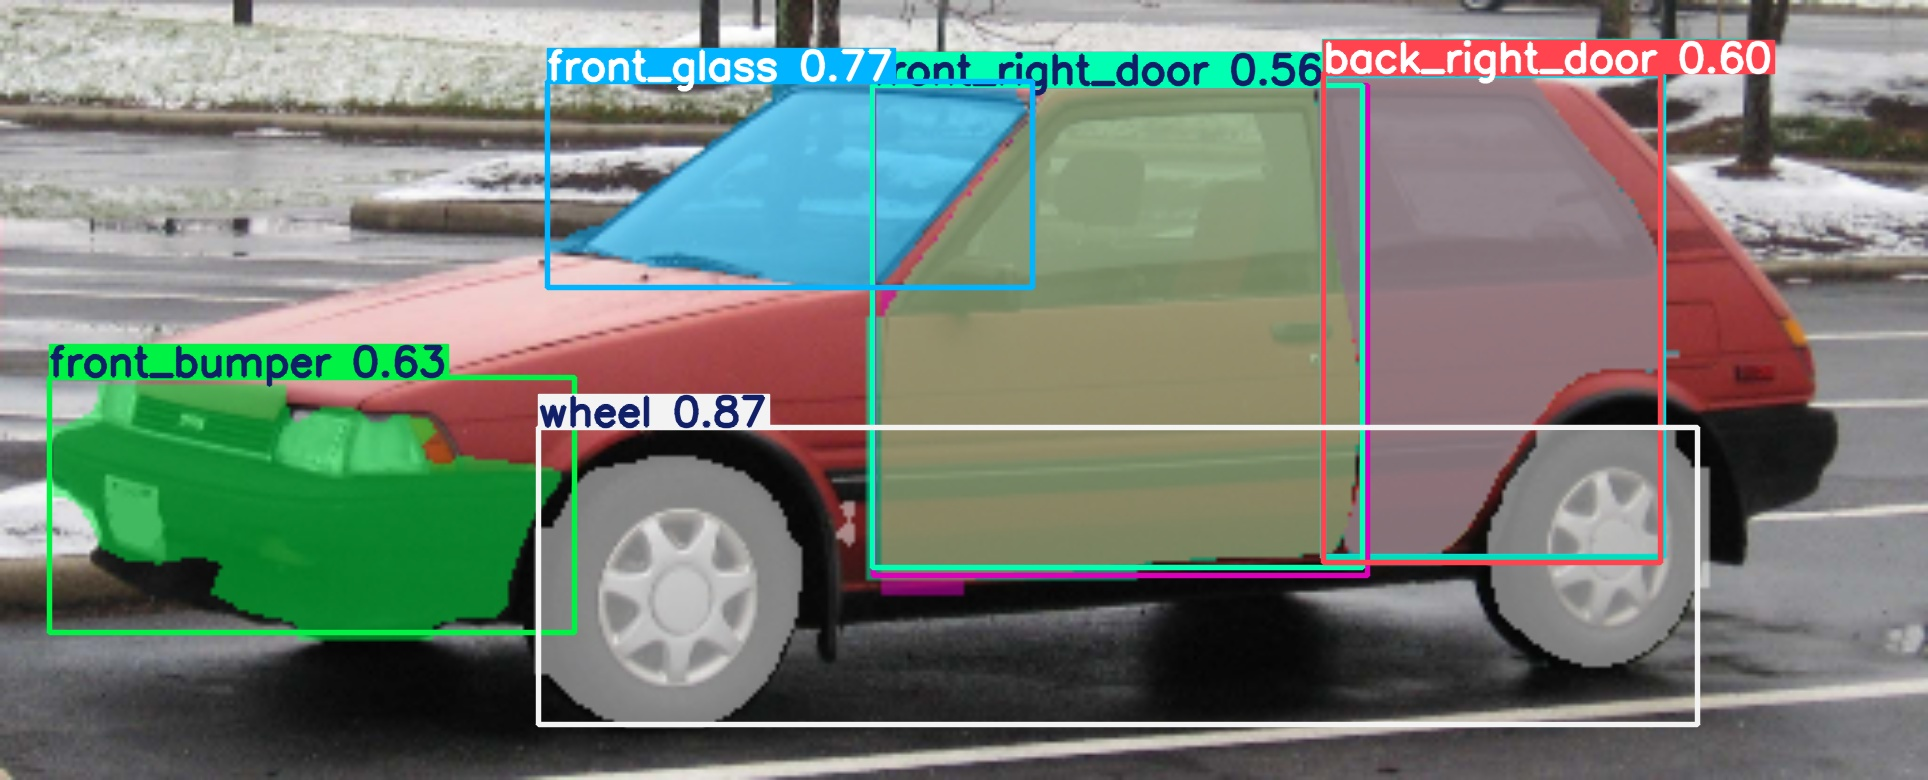

In [ ]:
from IPython.display import Image, display
import glob

# Cargar la primera imagen de resultados
result_img = glob.glob("runs/segment/predict2/*.jpg")[0]
display(Image(filename=result_img))

In [ ]:
import shutil
from pathlib import Path
import time

# Source model
SRC = Path("runs_carparts_seg/train_y11n_seg_fast/weights/best.pt")

# Destination in Google Drive (change folder name if you want)
DEST_DIR = Path("/content/drive/MyDrive/kopiloto/models")
DEST_DIR.mkdir(parents=True, exist_ok=True)

# Optional: add timestamp to filename
stamp = time.strftime("%Y%m%d-%H%M%S")
DEST = DEST_DIR / f"carparts_best_{stamp}.pt"

# Copy to Drive
shutil.copy2(SRC, DEST)
print(f"✅ Model saved to: {DEST}")

✅ Model saved to: /content/drive/MyDrive/kopiloto/models/carparts_best_20250814-000136.pt
